<a href="https://colab.research.google.com/github/tharungajula2/Portfolio/blob/main/Project207_%E2%8F%B3Capstone_Antidiabetic_drug_prescriptions(MarcoPeixeiro).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the required libraries and loading the data![Modelling Steps.png](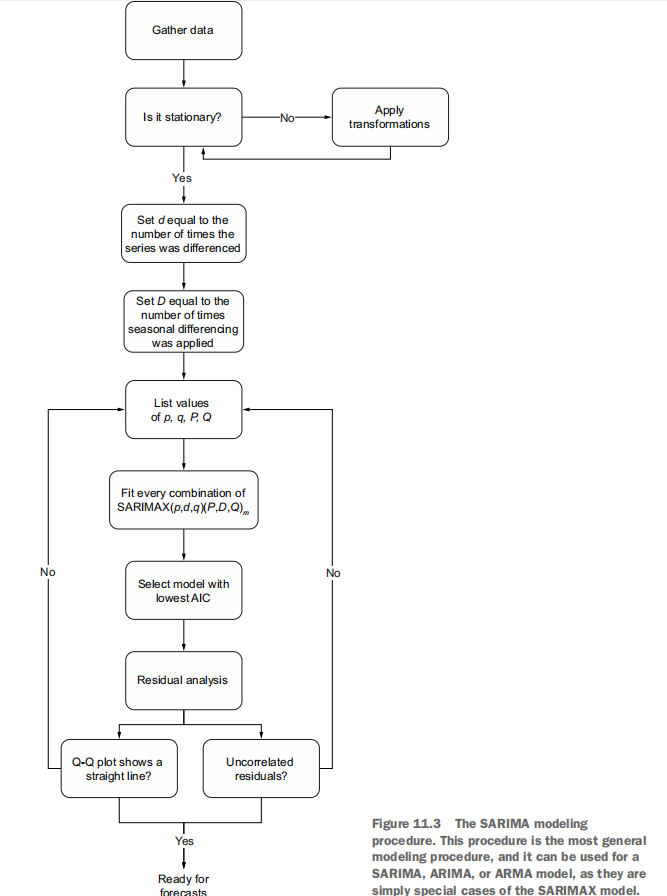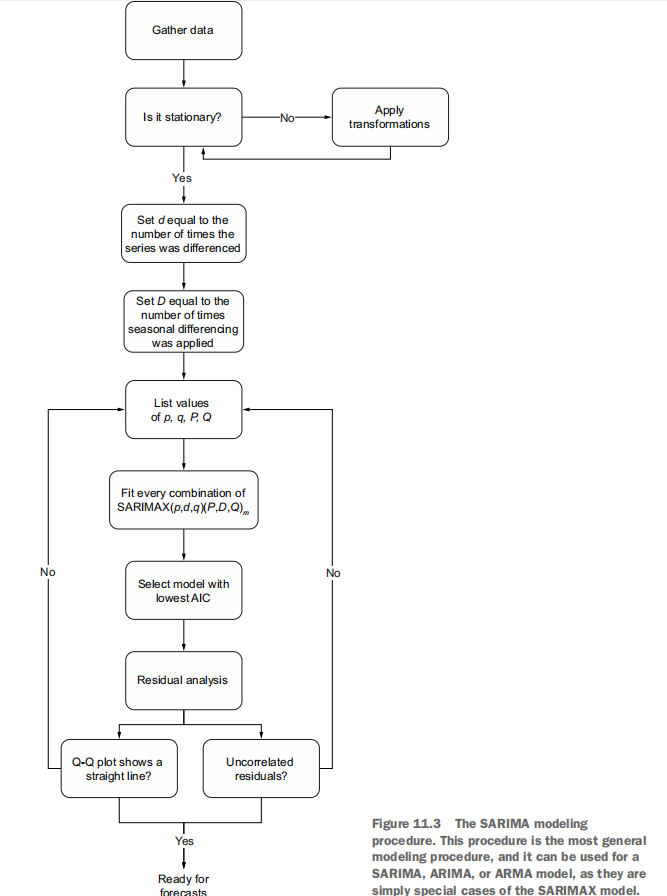)

 The objective of the project in this chapter is forecasting the number of antidiabetic drug prescriptions in Australia, from 1991 to 2008. In a professional setting, solving this problem would allow us to gauge the production of antidiabetic drugs, such as
to produce enough to meet the demand and but also avoid overproduction. The data
we’ll use was recorded by the Australian Health Insurance Commission.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/AusAntidiabeticDrug.csv')

In [ ]:
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [ ]:
df.tail()

,ds,y
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


## Visualization and Exploration

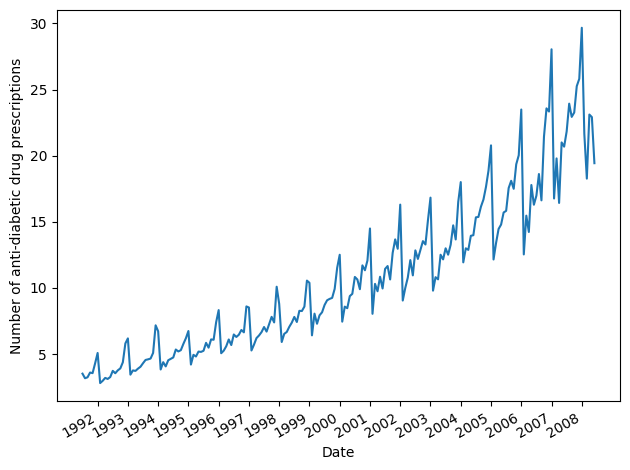

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

we see a clear trend in the time series, as the number of prescriptions
increases over time. Furthermore, we observe strong seasonality, as each year seems to start at a low value and end at a high value.

Steps to solve it:
1. The objective is to forecast 12 months of antidiabetic drug prescriptions. Use
the last 36 months of the dataset as a test set to allow for rolling forecasts.
2. Visualize the time series.
3. Use time series decomposition to extract the trend and seasonal components.
4. Based on your exploration, determine the most suitable model.
5. Model the series with the usual steps:

  a. Apply transformations to make it stationary.

  b. Set the values of d and D. Set the value of m.

  c. Find the optimal (p,d,q)(P,D,Q)m parameters.

  d. Perform residual analysis to validate your model.

6. Perform rolling forecasts of 12 months on the test set.
7. Visualize your forecasts.
8. Compare the model’s performance to a baseline. Select an appropriate baseline and error metric.
9. Conclude whether the model should be used or not.

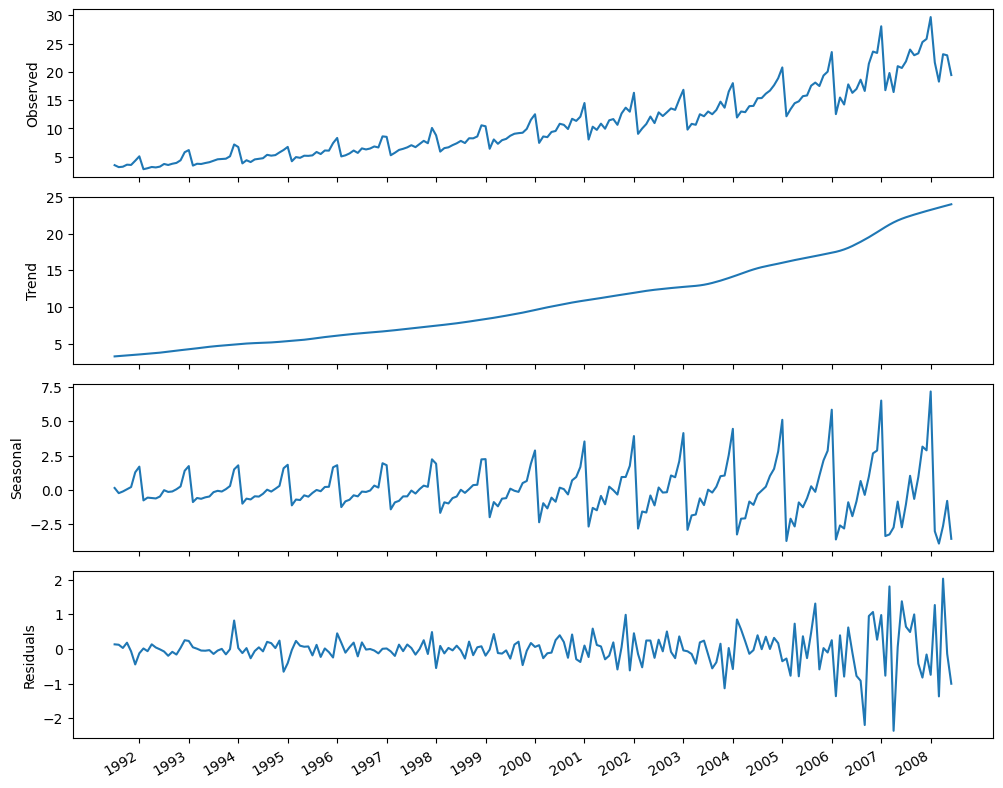

In [ ]:
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

We have a trend as well as clear seasonality. Plus, we do not have any exogenous variables to work with, so the SARIMAX model cannot be applied. Finally, we wish to predict only one target, meaning that a VAR model is also not relevant in this case. We’ve decided that a SARIMA(p,d,q)(P,D,Q)m model is the most suitable for modeling and forecasting this time series.

## Modeling

In [8]:
ad_fuller_result = adfuller(df.y)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 3.145185689306745
p-value: 1.0


p-value of 1.0, meaning that we cannot reject the null hypothesis, and we conclude that the series is not stationary. Thus, we must apply transformations to make it stationary

In [9]:
y_diff = np.diff(df.y, n=1)
ad_fuller_result = adfuller(y_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.4951721474497903
p-value: 0.1166534168646754


p-value of 0.12. Again, the p-value is greater than 0.05, meaning that the
series is not stationary. Let’s try applying a seasonal difference, since we noticed a strong seasonal pattern in the data. Recall that we have monthly data, meaning that m = 12. Thus, a seasonal difference subtracts values that are 12 timesteps apart.

In [10]:
y_diff_seasonal_diff = np.diff(y_diff, n=12)
ad_fuller_result = adfuller(y_diff_seasonal_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -19.84844009618371
p-value: 0.0


* p-value is 0.0. Thus, we can reject the null hypothesis and conclude that
our time series is stationary.
* Since we differenced the series once and took one seasonal difference, d = 1 and D = 1.
* Also, since we have monthly data, we know that m = 12.
* Therefore, we know that our final model will be a SARIMA(p,1,q)(P,1,Q)12 model

## Performing model selection

In [11]:
train = df.y[:168]
test = df.y[168:]
print(len(test))

36


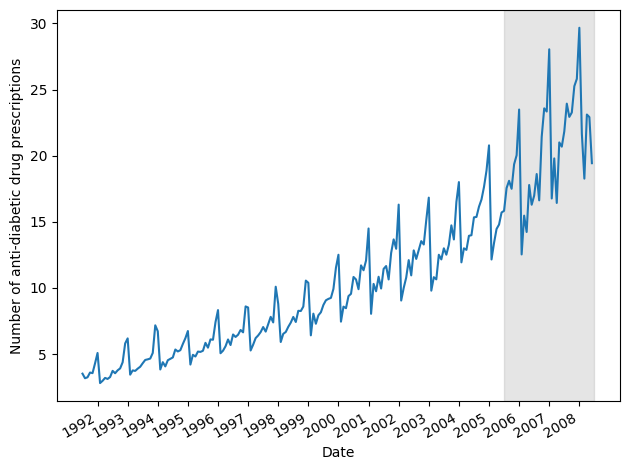

In [12]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA(p,1,q)(P,1,Q)12

using the optimize_SARIMAX function to find the values of p, q, P, and Q that minimize the AIC.

In [13]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

With the function defined, we can now decide on the range of values to try for p, q, P,and Q. Then we’ll generate a list of unique combinations of parameters.

In [14]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

In [15]:
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 0, 2, 3)",26.618683
1,"(3, 1, 1, 3)",270.951096
2,"(2, 4, 1, 3)",271.214367
3,"(3, 3, 1, 3)",271.466318
4,"(4, 1, 1, 3)",272.145292
...,...,...
620,"(0, 0, 0, 4)",351.680917
621,"(0, 0, 2, 4)",353.258486
622,"(0, 0, 0, 1)",354.751719
623,"(0, 0, 1, 0)",357.173706


* Here, 625 unique combinations are tested, since we have 5 possible values for 4 parameters.
* the result shows that the minimum AIC is achieved with
p = 2, q = 3, P = 1, and Q = 3. Therefore, the optimal model is a SARIMA(2,1,3)(1,1,3)12
model.

## Residual Analysis

we have the optimal model, we must analyze its residuals to determine
whether the model can be used or not. This will depend on the residuals, which should behave like white noise. If that is the case, the model can be used for forecasting.

In [27]:
SARIMA_model = SARIMAX(train, order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(2, 1, 3)x(1, 1, 3, 12)   Log Likelihood                -128.117
Date:                            Wed, 07 Feb 2024   AIC                            276.234
Time:                                    16:10:09   BIC                            306.668
Sample:                                         0   HQIC                           288.596
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1312      0.055    -20.725      0.000      -1.238      -1.024
ar.L2         -0.9658      0.064   

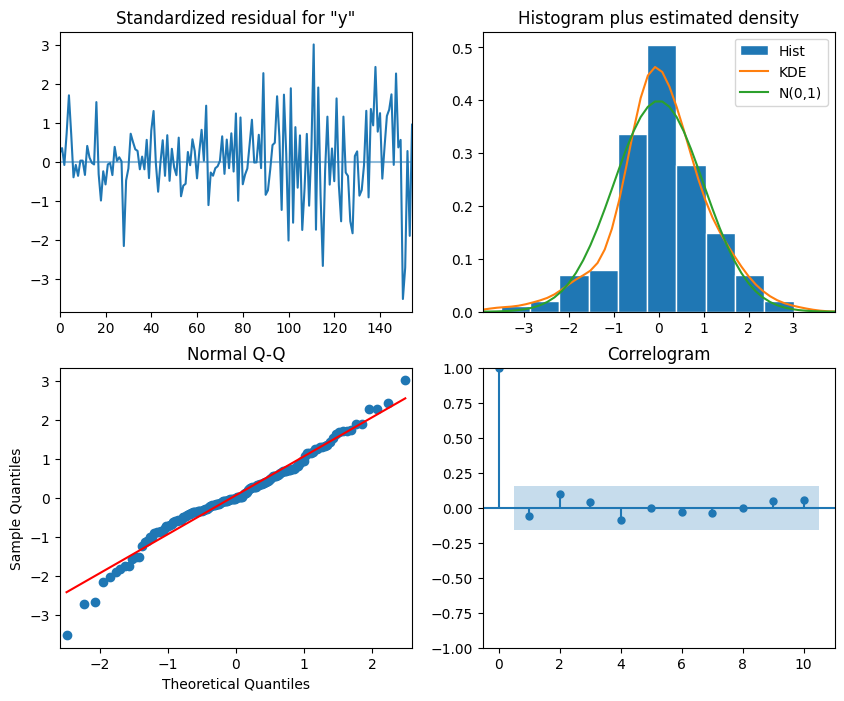

In [28]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

* In the top-left plot, the residuals have no trend over time,
and the **variance seems constant**.
* At the top right, the distribution of the residuals is very close to a **normal distribution**.
* This is further supported by the Q-Q plot at the bottom left, which displays a fairly straight line that sits on y = x.
* Finally, the correlogram at the bottom right shows no significant
coefficients after lag 0 , just like white noise.

we can conclude from this qualitative analysis that the residuals closely resemble white noise

Next, performing the Ljung-Box test, which determines whether the
residuals are independent and uncorrelated. The null hypothesis of the Ljung-Box
test states that the residuals are uncorrelated, just like white noise. Thus, we want
the test to return p-values larger than 0.05. In that case, we cannot reject the null
hypothesis and conclude that our residuals are independent, and therefore behave
like white noise.

In [29]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


all the p-values are above 0.05, so we do not reject the null hypothesis, and
we conclude that the residuals are independent and uncorrelated. We can conclude
that the model can used for forecasting

## Forecasting and evaluating the model’s performance

In [17]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []

        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)

        return pred_last_season

    elif method == 'SARIMA':
        pred_SARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)

        return pred_SARIMA

In [18]:
pred_df = df[168:]

pred_df

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


In [19]:
TRAIN_LEN = 168
HORIZON = 36
WINDOW = 12

pred_df['last_season'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

pred_df

,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728
173,2005-12-01,20.031291,18.869325
174,2006-01-01,23.486694,20.778723
175,2006-02-01,12.536987,12.154552
176,2006-03-01,15.467018,13.402392
177,2006-04-01,14.233539,14.459239


In [20]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.749386
169,2005-08-01,17.554701,15.370764,16.684883
170,2005-09-01,18.100864,16.142005,17.188720
171,2005-10-01,17.496668,16.685754,18.088932
172,2005-11-01,19.347265,17.636728,18.657838
173,2005-12-01,20.031291,18.869325,19.948363
174,2006-01-01,23.486694,20.778723,22.075817
175,2006-02-01,12.536987,12.154552,13.745806
176,2006-03-01,15.467018,13.402392,15.086059
177,2006-04-01,14.233539,14.459239,15.657270


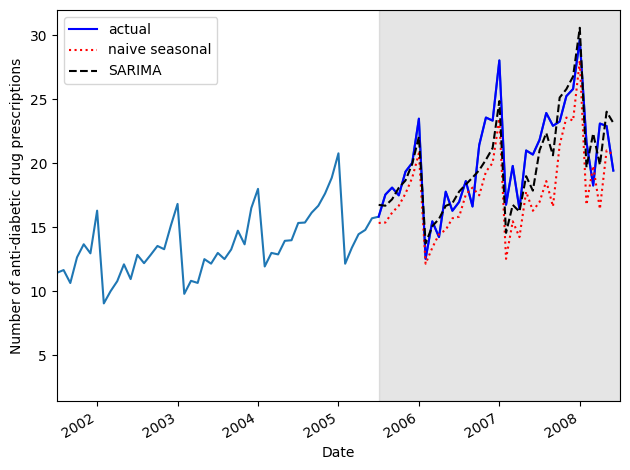

In [21]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

the predictions from the SARIMA model (the dashed
line) follow the actual values more closely than the naive seasonal forecasts (the dotted line). We can therefore intuitively expect the SARIMA model to have performed
better than the baseline method.

## Evaluation

In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.898811951220185


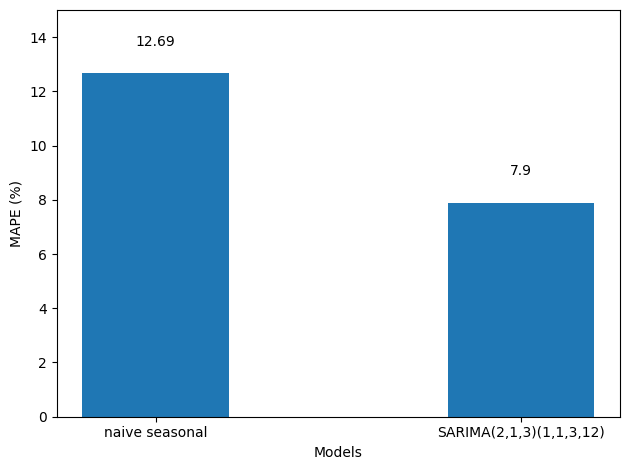

In [24]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

Since the SARIMA model achieves the lowest MAPE, we can conclude that the
SARIMA(2,1,3)(1,1,3)12 model should be used to forecast the monthly number of
antidiabetic drug prescriptions in Australia.